In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import pickle

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
data = pickle.load(open('db.pickle', 'rb'))

In [5]:
data.subreddit.value_counts()

politics                1286712
The_Donald               817118
worldnews                585547
funny                    580616
news                     580117
                         ...   
ElSalvador                    1
ODU                           1
claymore                      1
vehiclehomeless               1
MushroomVendorGaming          1
Name: subreddit, Length: 15696, dtype: int64

In [6]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/nick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
sub_list = ['politics']

data = data[data['subreddit'].isin(sub_list)]

In [8]:
data.head()

,_id,author,author_flair_text,body,can_gild,collapsed,collapsed_reason,controversiality,created_utc,distinguished,...,gilded,id,is_submitter,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id
3,ObjectId(5d5a006b42ec30098280ce9a),NaN,NaN,A few people were even claiming in 2012 that T...,NaN,NaN,NaN,0,1462060800,NaN,...,0,d2nvjj9,NaN,t3_4h4r9p,t1_d2nvgh5,1465550534,1,False,politics,t5_2cneq
14,ObjectId(5d5a006b42ec30098280cea5),NaN,NaN,I know you blame others for your problems. Ha...,NaN,NaN,NaN,1,1462060805,NaN,...,0,d2nvjmo,NaN,t3_4h6qba,t1_d2nvgzj,1465550535,1,False,politics,t5_2cneq
21,ObjectId(5d5a006b42ec30098280ceac),NaN,NaN,Does it come with an unearned seat in the Senate?,NaN,NaN,NaN,0,1462060809,NaN,...,0,d2nvjp1,NaN,t3_4h6e5h,t3_4h6e5h,1465550536,0,False,politics,t5_2cneq
30,ObjectId(5d5a006b42ec30098280ceb5),NaN,NaN,[removed],NaN,NaN,NaN,0,1462060814,NaN,...,0,d2nvjta,NaN,t3_4h6eb0,t1_d2nu1dh,1465550537,-5,False,politics,t5_2cneq
38,ObjectId(5d5a006b42ec30098280cebd),NaN,NaN,"No, it's about destroying public education to ...",NaN,NaN,NaN,0,1462060819,NaN,...,0,d2nvjwi,NaN,t3_4h6r3n,t3_4h6r3n,1465550539,1,False,politics,t5_2cneq


In [9]:
data = data[['body','controversiality','gilded','score','subreddit']]

In [10]:
data.head()

,body,controversiality,gilded,score,subreddit
3,A few people were even claiming in 2012 that T...,0,0,1,politics
14,I know you blame others for your problems. Ha...,1,0,1,politics
21,Does it come with an unearned seat in the Senate?,0,0,0,politics
30,[removed],0,0,-5,politics
38,"No, it's about destroying public education to ...",0,0,1,politics


In [11]:
len(data)

1286712

In [12]:
data = data[data['score']>50]

In [13]:
len(data)

20199

In [14]:
score_df = data.sort_values(by='score',ascending = False)

In [15]:
score_df.head()

,body,controversiality,gilded,score,subreddit
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics
550099,I just want to remind everyone of something.\n...,0,6,5226,politics
884430,Then why the fuck are people voting for them?,0,1,4938,politics
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics


In [17]:
len(score_df)

20199

In [18]:
score_df = score_df[score_df['body'] != '[deleted]']

In [20]:
score_df['body_length'] = score_df['body'].apply(lambda x: len(str(x).split(' ')))

In [21]:
score_df = score_df[score_df['body_length'] >= 5]

In [22]:
len(score_df)

18469

### Manipulation

In [23]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics,82
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics,32
550099,I just want to remind everyone of something.\n...,0,6,5226,politics,419
884430,Then why the fuck are people voting for them?,0,1,4938,politics,9
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics,12


In [24]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(score_df['body']))

In [25]:
data_words[1]

['trump',
 'supporters',
 'said',
 'trump',
 'was',
 'genius',
 'for',
 'agreeing',
 'to',
 'sanders',
 'proposal',
 'for',
 'debate',
 'now',
 'just',
 'watch',
 'as',
 'his',
 'supporters',
 'explain',
 'that',
 'trump',
 'genius',
 'for',
 'turning',
 'down',
 'sanders',
 'proposal']

In [27]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [28]:
stop_words.extend(['http', 'https', 'imgur', 'com', 'jpg', 'bernie', 'hillary', 'trump', 'www', 'sander', 'sanders', 'clinton', 'donald', 'youtube'])

In [29]:
stop_words.extend(['reddit', 'org'])

In [30]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [31]:
print(trigram[bigram[data_words[19]]])

['editing', 'as', 'new', 'outlets', 'report', 'on', 'the', 'story', 'keep', 'hitting', 'the', 'character', 'post', 'limit', 'you', 'can', 'see', 'the', 'big', 'list', 'here', 'google', 'doc', 'https', 'docs_google', 'com', 'spreadsheets', 'lhcoacw', 'nd', 'xpmrgbqsssw', 'epg', 'adm', 'ihdes', 'edit', 'usp', 'sharing', 'also', 'thanks', 'for', 'the', 'gold', 'you', 'know', 'who', 'you', 'are', 'news', 'outlet', 'headline', 'link', 'politico', 'state_dept_watchdog', 'clinton', 'violated', 'email', 'rules', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'email', 'inspector_general_report', 'politico', 'clinton', 'expressed', 'worries', 'about', 'exposure', 'of', 'personal', 'emails', 'at', 'state_dept', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'personal', 'email', 'worry', 'politico', 'republicans', 'rip', 'clinton', 'after', 'ig', 'email', 'report', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'email', 'report', 'gop', 'politico', 'cli

In [32]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['honestly', 'mean', 'believe', 'important', 'job', 'world', 'toughest_job', 'world', 'willing', 'campaign', 'vote', 'willing', 'think', 'find', 'know', 'willing', 'entire', 'process', 'people', 'try', 'push', 'ever']]


In [33]:
pickle.dump(data_lemmatized, open('lem.pickle', 'wb'))

In [34]:
data_lemmatized2 = pickle.load(open('lem.pickle', 'rb'))

In [35]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts = data_lemmatized2

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 3), (18, 2)]]


In [36]:
#Readable version:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('believe', 1),
  ('campaign', 1),
  ('entire', 1),
  ('ever', 1),
  ('find', 1),
  ('honestly', 1),
  ('important', 1),
  ('job', 1),
  ('know', 1),
  ('mean', 1),
  ('people', 1),
  ('process', 1),
  ('push', 1),
  ('think', 1),
  ('toughest_job', 1),
  ('try', 1),
  ('vote', 1),
  ('willing', 3),
  ('world', 2)]]

In [37]:
score_df['processed_body'] = data_lemmatized2

In [38]:
pickle.dump(score_df, open('score_df.pickle', 'wb'))

In [39]:
score_df = pickle.load(open('score_df.pickle', 'rb'))

In [40]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length,processed_body
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics,82,"[honestly, mean, believe, important, job, worl..."
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics,32,"[supporter, say, agree, proposal, watch, suppo..."
550099,I just want to remind everyone of something.\n...,0,6,5226,politics,419,"[want, remind, loathsome, people, ever, fuckin..."
884430,Then why the fuck are people voting for them?,0,1,4938,politics,9,"[fuck, people, vote]"
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics,12,"[place, man, race]"


### Building the Topic Model

In [41]:
from gensim import corpora, models
lda_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=7)

In [42]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -8.063585149655903


In [63]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2019-08-22 06:33:36,593 : INFO : using ParallelWordOccurrenceAccumulator(processes=31, batch_size=64) to estimate probabilities from sliding windows
2019-08-22 06:33:39,560 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,569 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,566 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,566 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,564 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,577 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,580 : INFO : accumulator serialized
2019-08-22 06:33:39,563 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,581 : INFO : accumulator serialized
2019-08-22 06:33:39,580 : INFO : accumulator serialized
2019-08-22 06:33:39,582 : INFO : accumulator serialized
2019-08-22 06:33:39,585 : INFO : serializing accumulator to return 


Coherence Score:  0.4599709957738477


### Visualization Topics

In [43]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [44]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.009600  0.006652       1        1  15.865026
3      0.006917 -0.005568       2        1  14.747936
5      0.002133  0.027109       3        1  12.800627
0      0.034944 -0.007181       4        1  12.445422
1     -0.040892  0.003352       5        1  12.200563
6     -0.018439 -0.027354       6        1  11.322537
7      0.007483 -0.021055       7        1  10.748443
4     -0.001747  0.024045       8        1   9.869445, topic_info=          Term         Freq        Total Category  logprob  loglift
16        vote  2582.000000  2582.000000  Default  30.0000  30.0000
81          go  2829.000000  2829.000000  Default  29.0000  29.0000
148      thing  1351.000000  1351.000000  Default  28.0000  28.0000
428     debate   974.000000   974.000000  Default  27.0000  27.0000
374     server   845.000000   845.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
8         know   121.097939  1571.024902   Topic8  -5.5790  -0.2472
150       time   117.529427  1527.138413   Topic8  -5.6089  -0.2487
444   election    98.175774   826.200313   Topic8  -5.7888   0.1856
13       think   108.875200  2052.411950   Topic8  -5.6854  -0.6208
47   candidate   102.150733  1278.878124   Topic8  -5.7491  -0.2116

[707 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
11863      1  0.765658  accepted
592        1  0.080700    access
592        2  0.152433    access
592        3  0.197266    access
592        4  0.040350    access
...      ...       ...       ...
167        5  0.144019      year
167        6  0.144019      year
167        7  0.137618      year
167        8  0.118416      year
9216       4  0.623288       yup

[1949 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 6, 1, 2, 7, 8, 5])

### Mallet Model

In [51]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/nick/Documents/Projects/alt-reddit/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word) #Num topics identified below and re-run.

In [52]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('debate', 0.03377273485733356),
   ('good', 0.033038544969130654),
   ('run', 0.027632237610545635),
   ('bad', 0.02032371099616219),
   ('back', 0.017520440513932922),
   ('supporter', 0.016452527949274154),
   ('president', 0.015851827131653597),
   ('thing', 0.015050892708159519),
   ('happen', 0.014617053228766894),
   ('agree', 0.014116469214083096)]),
 (1,
  [('money', 0.021641379710481273),
   ('pay', 0.019175538858750833),
   ('job', 0.015897421020568014),
   ('year', 0.013721679092570566),
   ('work', 0.01195207565779931),
   ('country', 0.009805343622175161),
   ('high', 0.009196135882335877),
   ('spend', 0.009138116097589279),
   ('give', 0.00861593803486989),
   ('government', 0.007078413739085028)]),
 (2,
  [('call', 0.02711181560002642),
   ('point', 0.024238821742289147),
   ('medium', 0.022752790436562975),
   ('lie', 0.018162604847764347),
   ('show', 0.0174691235717588),
   ('fact', 0.017337031900138695),
   ('talk', 0.015091473482596922),
   ('support', 0.0

### Optimal Topics

In [53]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [54]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

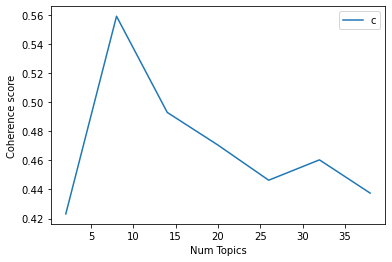

In [55]:
# Show graph use peak to identify optimal number of topics. It's 8.
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Rerun LDA with Optimal Number of Topics

In [56]:
optimal_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=31)

In [57]:
optimal_model.print_topics(num_words=10)

[(0,
  '0.011*"say" + 0.010*"go" + 0.008*"vote" + 0.008*"email" + 0.007*"even" + 0.007*"would" + 0.007*"thing" + 0.006*"people" + 0.006*"make" + 0.005*"good"'),
 (1,
  '0.014*"would" + 0.010*"go" + 0.009*"email" + 0.008*"think" + 0.008*"say" + 0.006*"people" + 0.006*"see" + 0.006*"server" + 0.005*"well" + 0.005*"vote"'),
 (2,
  '0.014*"say" + 0.013*"get" + 0.012*"make" + 0.010*"go" + 0.009*"would" + 0.007*"people" + 0.007*"know" + 0.006*"even" + 0.006*"email" + 0.005*"time"'),
 (3,
  '0.011*"vote" + 0.011*"people" + 0.010*"supporter" + 0.009*"go" + 0.009*"candidate" + 0.007*"would" + 0.007*"want" + 0.007*"think" + 0.006*"say" + 0.006*"actually"'),
 (4,
  '0.013*"people" + 0.010*"know" + 0.008*"would" + 0.007*"get" + 0.007*"state" + 0.007*"vote" + 0.006*"take" + 0.006*"think" + 0.006*"good" + 0.005*"say"'),
 (5,
  '0.013*"people" + 0.012*"would" + 0.011*"debate" + 0.011*"even" + 0.010*"say" + 0.010*"go" + 0.007*"make" + 0.006*"think" + 0.005*"time" + 0.005*"look"'),
 (6,
  '0.018*"vote"

In [58]:
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.006517  0.014971       1        1  16.065000
1      0.016457  0.011399       2        1  15.312332
0      0.013073 -0.001564       3        1  13.863302
6      0.006347 -0.017054       4        1  12.692255
5     -0.009613 -0.015821       5        1  11.907937
3      0.003463 -0.033642       6        1  11.841848
4      0.015824  0.029160       7        1  10.958386
7     -0.052066  0.012551       8        1   7.358939, topic_info=          Term         Freq        Total Category  logprob  loglift
10      people  3383.000000  3383.000000  Default  30.0000  30.0000
16        vote  2603.000000  2603.000000  Default  29.0000  29.0000
428     debate  1007.000000  1007.000000  Default  28.0000  28.0000
165      would  2993.000000  2993.000000  Default  27.0000  27.0000
150       time  1507.000000  1507.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
24   supporter    92.691194  1376.798857   Topic8  -5.5528  -0.0890
160       well    85.074069  1127.363019   Topic8  -5.6385   0.0251
46        call    75.559104   813.346226   Topic8  -5.7571   0.2330
67        even    82.610450  1751.625883   Topic8  -5.6679  -0.4449
384      state    76.014536  1327.670379   Topic8  -5.7511  -0.2510

[707 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
7435      7  0.720512      ac
592       1  0.204387  access
592       2  0.352241  access
592       3  0.086973  access
592       4  0.091322  access
...     ...       ...     ...
167       4  0.171890    year
167       5  0.143064    year
167       6  0.050179    year
167       7  0.165484    year
167       8  0.046976    year

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 7, 6, 4, 5, 8])

### T-SNE

In [59]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    [topic_weights.append(w for i, w in row_list)]
#     topic_weights.append(row_list[0][1])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18215 samples in 0.023s...
[t-SNE] Computed neighbors for 18215 samples in 0.524s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18215
[t-SNE] Computed conditional probabilities for sample 2000 / 18215
[t-SNE] Computed conditional probabilities for sample 3000 / 18215
[t-SNE] Computed conditional probabilities for sample 4000 / 18215
[t-SNE] Computed conditional probabilities for sample 5000 / 18215
[t-SNE] Computed conditional probabilities for sample 6000 / 18215
[t-SNE] Computed conditional probabilities for sample 7000 / 18215
[t-SNE] Computed conditional probabilities for sample 8000 / 18215
[t-SNE] Computed conditional probabilities for sample 9000 / 18215
[t-SNE] Computed conditional probabilities for sample 10000 / 18215
[t-SNE] Computed conditional probabilities for sample 11000 / 18215
[t-SNE] Computed conditional probabilities for sample 12000 / 18215
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [60]:
print(mycolors)

['#1f77b4' '#ff7f0e' '#2ca02c' '#d62728' '#9467bd' '#8c564b' '#e377c2'
 '#7f7f7f' '#bcbd22' '#17becf']


In [62]:
pickle.dump(vis, open('politics_vis.pickle', 'wb'))




